# Consumo de energia elétrica mensal da Austrália

*Significado dos nomes utilizados no código:*

* **df_** → DataFrame: uma tabela (mas só utilizamos como **lista**) com linhas e colunas nomeadas
* **arr_** → Array: uma lista unidimensional com valores (**Todos os DataFrames também tem seus valores em forma de arrays para facilitar a manipulação ao longo do código**)
* **(*dif*)** → Diferenciado: indica que o DataFrame sendo exibido foi diferenciado

In [1]:
# Importando bibliotecas essenciais
import math
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

from sklearn import svm, datasets
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [2]:
# Caminho da pasta com os dados
caminho_bdd = '../../../../../Faculdade/Estudo TCC/R/BDD'

In [3]:
# Um booleano que define se as séries importadas passarão por diferenciação ou não
diferenciado = True

In [4]:
# Número de lag
lag = 12

## Funções úteis
#### Ao longo do código, existem funções que serão úteis para evitar repetições desnecessárias ao longo do código:

* Uma função para alterar o index das linhas dos DataFrames, para que fique mais claro a data correspondente para cada valor do DataFrame (*A etapa de diferenciação faz com que a data de início seja a partir do segundo mês, já que a primeira amostra é "perdida" na diferenciação*):

In [5]:
# Mudança no nome das linhas para facilitar a leitura
# Muda os valores do index para MÊS/ANO
def mudar_index(df, nome_coluna='Consumo', start='', diferenciado=diferenciado):
    if type(df).__module__ == np.__name__:
        df = pd.DataFrame(df, columns=[nome_coluna]) 
    if not start:
        start = '02/01/1956' if diferenciado else '01/01/1956'
    datas = pd.date_range(start=start, periods=len(df), freq='1M')
    meses = {1:'JAN', 2:'FEV', 3:'MAR', 4:'ABR', 5:'MAI', 6:'JUN', 7:'JUL', 8:'AGO', 9:'SET', 10:'OUT', 11:'NOV', 12:'DEZ'}
    index = [f'{meses[data.month]}/{data.year}' for data in datas]
    df = pd.DataFrame({nome_coluna: list(df[nome_coluna])}, index = index)
    return df

* Uma função que recebe uma série e seus *labels* como parâmetro e plota os gráficos com estes dados:

In [6]:
# Plotar gráficos para facilitar a visualização
def plotar_grafico(series, labels, ticks='', personalize=False):
    nome_coluna = ''
    plt.figure(figsize = (15,10))
    for j, i in enumerate(series):
        if personalize:
            if j==1:
                plt.plot(series[i], label = i, linestyle='solid')
            elif j==2:
                plt.plot(series[i], label = i, linestyle='dotted', color='m')
            else:
                plt.plot(series[i], label = i)
        else:
            plt.plot(series[i], label = i)
        nome_coluna = i
    titulo = labels["titulo"]
    plt.title(titulo)
    plt.xlabel(labels['x_label'])
    ax = plt.gca()
    if not ticks:
        ticks = math.floor(len(series[nome_coluna])/13)
    ax.set_xticks(ax.get_xticks()[::ticks])
    plt.ylabel(labels['y_label'])
    plt.legend()
    plt.show()

# Base de dados

## Valores mensais de consumo de energia elétrica (em 1e6 kWh)

Valores originais do consumo de energia elétrica na Austrália

In [7]:
df_series_orig = pd.read_csv(f'{caminho_bdd}/series.txt', sep='\n', names=['Consumo_kWh'], header=None)
df_series_orig = mudar_index(df_series_orig, 'Consumo_kWh')
arr_series_orig =  np.array(df_series_orig['Consumo_kWh'].copy())

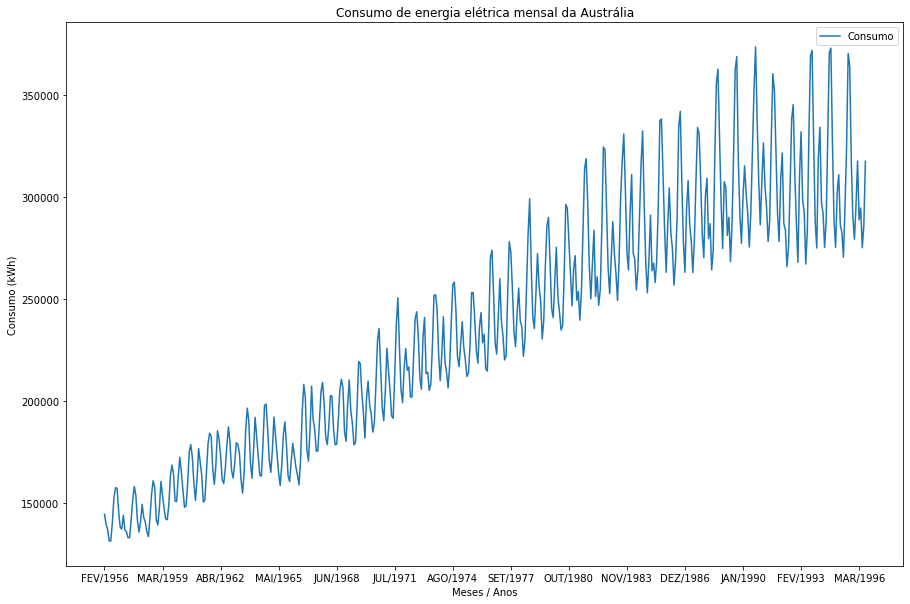

In [8]:
plotar_grafico({'Consumo': df_series_orig} , 
               {'titulo': 'Consumo de energia elétrica mensal da Austrália',
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo (kWh)'})

## Valores mensais de consumo de energia elétrica normalizados

A série temporal da base de dados apresenta as medições da potência ativa de consumo (kWh), no entanto, os dados serão trabalhados com valores normalizados para que a modelagem dos dados seja satisfatória. 
Estes dados serão a nossa série temporal, **vamos trabalhar com os dados normalizados**.

In [9]:
# Importação
df_series = pd.read_csv(f'{caminho_bdd}/series_norm.txt', sep='\n', names=['Consumo'], header=None)

In [10]:
# Transformar em lista
df_series = mudar_index(df_series, 'Consumo')
arr_series =  np.array(df_series['Consumo'].copy())

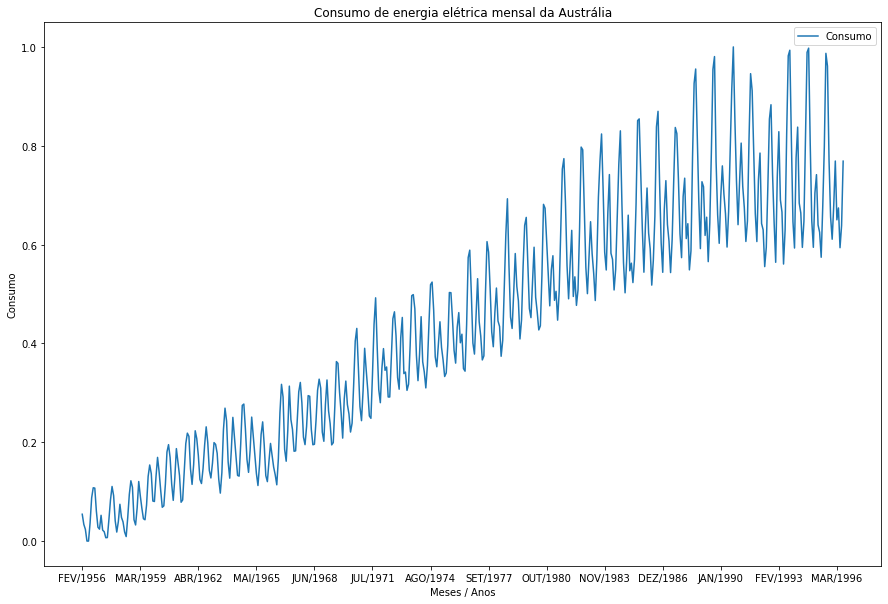

In [11]:
plotar_grafico({'Consumo': df_series} , 
               {'titulo': 'Consumo de energia elétrica mensal da Austrália',
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

### Decomposição da Série

Toda série temporal pode ser decomposta em 3 partes: **tendência**, **sazonalidade** e **resíduo**, abaixo a separação dessas partes:

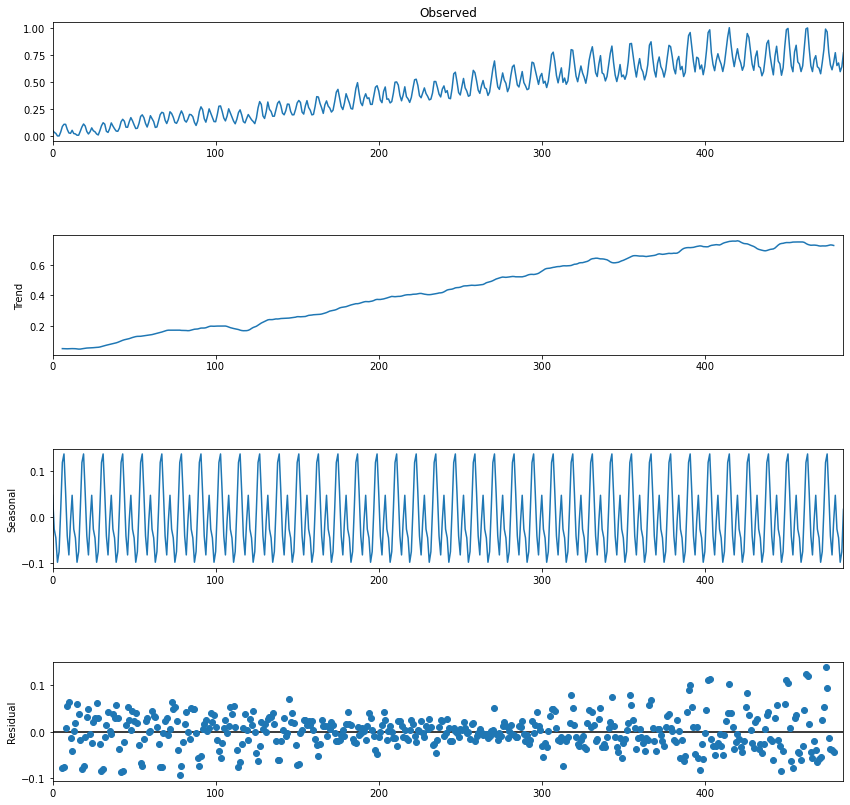

In [12]:
# Gráfico mensal com ciclos que se repetem a cada 12 meses (1 ano)
season = seasonal_decompose(arr_series, freq = 12)
fig = season.plot();
fig.set_size_inches(13,13)

## Teste de estacionaridade da série

<h3>Média da Série</h3>

Uma série estacionária tem média constante durante o tempo, não existe tendências de alta ou de baixa. A razão disso é que tendo uma média constante com variações ao redor desta média fica muito mais fácil de extrapolar ao futuro.

Há casos que a variância é pequena em relação à média e usá-la pode ser uma boa métrica para fazer previsões para o futuro.

Caso a série não seja estacionária a previsão para o futuro não será eficiente, pois as variações de valores ao redor da média se afastam significativamente. A série original não apresenta estacionariedade como pode ser visto abaixo:

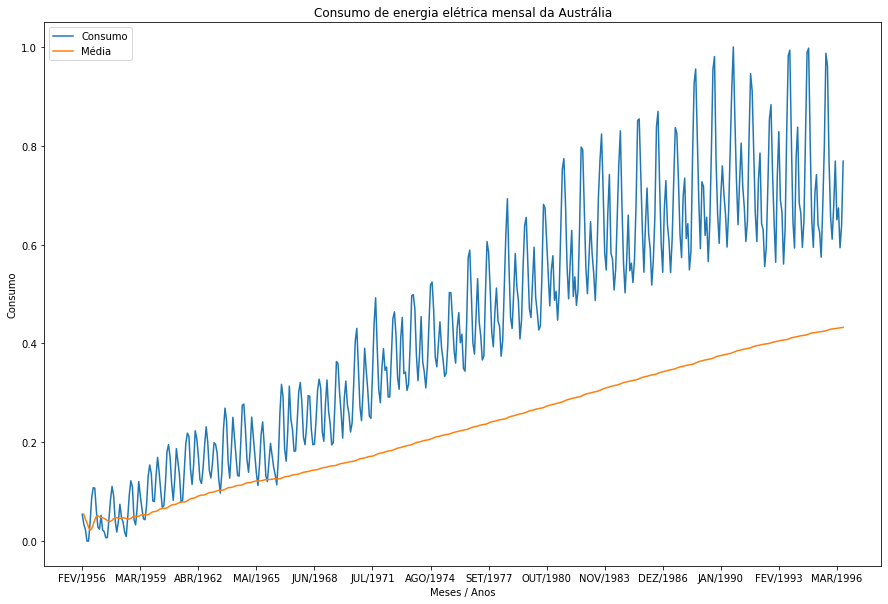

In [13]:
arr_series_orig_mean = [np.mean(arr_series[:x]) for x in range(len(arr_series))]

plotar_grafico({'Consumo': df_series, 'Média': arr_series_orig_mean}, 
               {'titulo': 'Consumo de energia elétrica mensal da Austrália', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

No gráfico acima claramente nota-se uma **tendência crescente** (média crescente), gradativamente subindo. Sendo assim, conclui-se que esta é uma **série não estacionária**.

Claramente a série tem uma tendência de alta. Porém é indicado utilizar testes estatísticos para confirmar se a séries é estacionária, vamos usar dois testes: o teste de Dickey Fuller e o teste KPSS.

### Teste Dickey Fuller

Primeiramente vamos usar o teste de Dickey Fuller, usarei o valor P base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária.

Além disso, existe o Teste estatístico do modelo, onde estes valores podem ser comparados com os valores críticos de 1%, 5% e 10%, caso o teste estatístico esteja abaixo de algum valor critico escolhido a série será estacionária:

In [14]:
#Teste de Dickey Fuller
def teste_dickey_fuller(serie):
    adfinput = adfuller(serie, maxlag = lag)
    adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                              'Lags Usados','Número de observações usadas'])
    adftest = round(adftest,4)

    for key, value in adfinput[4].items():
        adftest[f'Valores Críticos {key}'] = value.round(4) 
    return adftest

In [15]:
teste_dickey_fuller(arr_series)

Teste Estatistico Dickey Fuller     -1.4407
Valor-P                              0.5626
Lags Usados                         12.0000
Número de observações usadas       473.0000
Valores Críticos 1%                 -3.4443
Valores Críticos 5%                 -2.8677
Valores Críticos 10%                -2.5700
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série **não é estacionária** (Valor P de 56% e o *valor crítico de 5%* é menor que o teste estatístico)

### Teste KPSS

Agora vamos analisar a série com o teste KPSS, ao contrário do teste de Dickey Fuller, o teste KPSS já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5% ou o teste estatístico for menor que algum valor crítico escolhido:

In [16]:
#Teste KPSS
def teste_kpss(serie):
    kpss_input = kpss(serie, nlags = lag)
    kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
    kpss_test = round(kpss_test,4)

    for key, value in kpss_input[3].items():
        kpss_test[f'Valores Críticos {key}'] = value 
    return kpss_test

In [17]:
teste_kpss(arr_series)

Teste Statistico KPSS     3.816
Valor-P                   0.010
Lags Usados              12.000
Valores Críticos 10%      0.347
Valores Críticos 5%       0.463
Valores Críticos 2.5%     0.574
Valores Críticos 1%       0.739
dtype: float64

Confirmando o teste de Dickey Fuller, o teste KPSS também mostra que a série **não é estacionária**, pois o valor P está em 1% (<5%) e o teste estatístico está acima de qualquer valor crítico.

### Diferenciação

A diferenciação é um método válido para transformar as séries em estacionárias, já que sua aplicação é voltada para a remoção de sinais de tendência e redução da variância. A diferenciação é simplesmente o resultante da diferença entre o valor do período atual e o valor do período anterior, que é calculado ao longo de toda a série, gerando um conjunto de valores correspondentes aos resultados dessa diferença.

In [18]:
# Diferenciação 
if (diferenciado):
    arr_series = np.diff(arr_series)
    df_series = mudar_index(arr_series, 'Consumo (dif)')

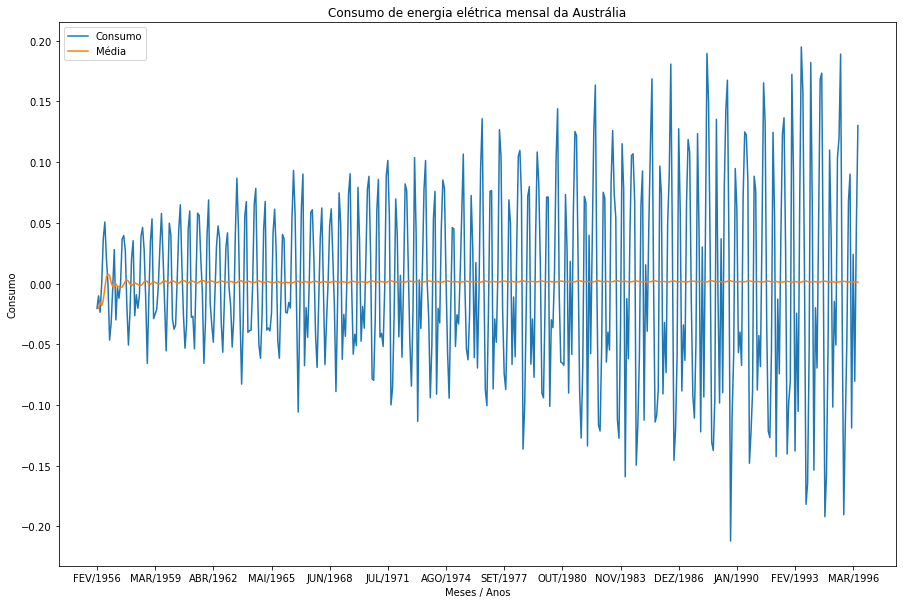

In [19]:
arr_series_mean = [np.mean(arr_series[:x]) for x in range(len(arr_series))]

plotar_grafico({'Consumo': df_series, 'Média': arr_series_mean}, 
               {'titulo': 'Consumo de energia elétrica mensal da Austrália', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

Como é possível observar na representaçao da série acima, sua média agora é constante, indicando que possívelmente a série agora **é estacionária**.
Para confirmar, vamos utilizar novamente os testes de Dickey-Fuller e KPSS.

In [20]:
teste_dickey_fuller(arr_series)

Teste Estatistico Dickey Fuller     -9.9265
Valor-P                              0.0000
Lags Usados                         11.0000
Número de observações usadas       473.0000
Valores Críticos 1%                 -3.4443
Valores Críticos 5%                 -2.8677
Valores Críticos 10%                -2.5700
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série **é estacionária** (Valor P de 0% e o *valor crítico de 5%* não é menor que o teste estatístico)

In [21]:
teste_kpss(arr_series)

Teste Statistico KPSS     0.0347
Valor-P                   0.1000
Lags Usados              12.0000
Valores Críticos 10%      0.3470
Valores Críticos 5%       0.4630
Valores Críticos 2.5%     0.5740
Valores Críticos 1%       0.7390
dtype: float64

Confirmando o teste de Dickey Fuller, o teste KPSS também mostra que a série **é estacionária**, pois o valor P está em 10% (>5%) e o teste estatístico está abaixo de qualquer valor crítico.

# Previsão do ARIMA (obtido com o Rstudio)

**ARIMA**: Modelo auto-regressivo integrado de médias móveis (autoregressive integrated moving average ou ARIMA) é uma generalização de um modelo auto-regressivo de médias móveis (ARMA). Ambos os modelos são ajustados aos dados da série temporal para entender melhor os dados ou para prever pontos futuros na série.

A previsão do ARIMA foi obtida no Rstudio com ajuda da função Auto ARIMA, que define automaticamente os melhores parâmetros ***p***, ***d*** e ***q*** para o modelo em questão.

### Divisão dos dados em base de *treinamento* e de *teste*

Quando vamos criar um modelo de previsão de séries temporais o ideal é separar os dados em duas partes:

* **Treinamento**: estes dados serão a base principal para definir os coeficientes/parâmetros do modelo;
* **Teste (validação)**: são dados que serão separados e não foram vistos pelo modelo e serão usados para testá-lo e comparar com as previsões (geralmente comparando os valores passo-a-passo).

Para criar o modelo de previsão do ARIMA no RStudio, os dados foram divididos em um conjunto de treinamento e um de teste.

No caso do consumo de energia na Autrália temos 486 meses, onde, na técnica ARIMA, a base de *treinamento* corresponde aos **primeiros 340 meses** (aproximadamente 28 anos ~70%) e os **últimos 145 meses** (aproximadamente 12 anos ~30%) foram utilizados como base de *testes*:

In [22]:
# Cálculo automático do numero de meses de treino (70% da série completa)
meses_treino = math.ceil(len(arr_series)*0.7)

In [23]:
print(f'Meses para treino: {meses_treino}\nMeses para teste: {len(arr_series)-meses_treino}')

Meses para treino: 340
Meses para teste: 145


In [24]:
# É necessário somar 1 ao valor dos meses de treino, para que o python obtenha a quantidade correta de amostras, 
# já que o intervalo superior é aberto.
meses_treino += 1

df_series_train = pd.DataFrame(data = df_series_orig.iloc[:meses_treino, 0].copy())
df_series_test = pd.DataFrame(data = df_series_orig.iloc[meses_treino:, 0].copy())

arr_series_train = np.array(df_series_train.copy())
arr_series_test = np.array(df_series_test.copy())

A divisão dos dados no ARIMA ficou como apresentado no gráfico abaixo.

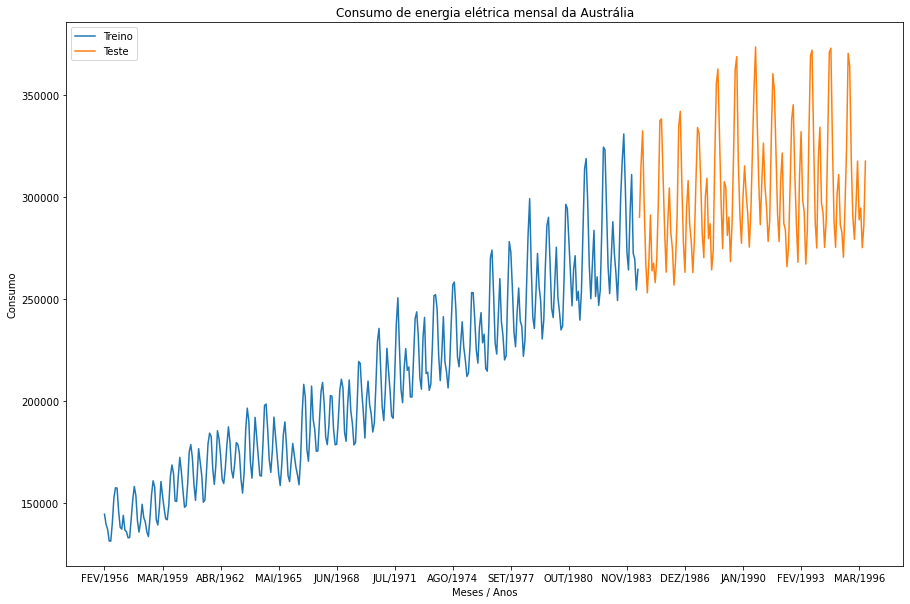

In [25]:
plotar_grafico({'Treino': df_series_train, 'Teste': df_series_test}, 
               {'titulo': f'Consumo de energia elétrica mensal da Austrália', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'},
                 ticks = 37)

Vamos importar o modelo obtido pelo ARIMA

In [26]:
# Importação
df_arima = pd.read_csv(f'{caminho_bdd}/predicted_ARIMA_eletric.csv', sep=',', header = 0, 
                       names = ['Modelo_ARIMA'])

df_arima = mudar_index(df_arima, 'Modelo_ARIMA')

arr_arima = np.array(df_arima['Modelo_ARIMA'].copy())

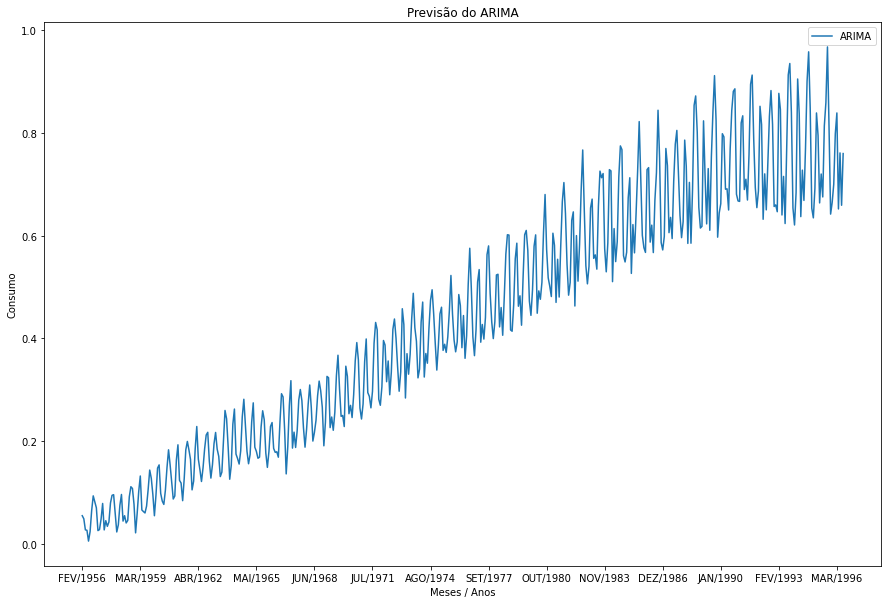

In [27]:
plotar_grafico({'ARIMA': df_arima}, 
               {'titulo': 'Previsão do ARIMA', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

Vamos realizar os testes de Dickey-Fuller e KPSS para verificar se o modelo do ARIMA é estacionário

In [28]:
teste_dickey_fuller(arr_arima)

Teste Estatistico Dickey Fuller     -2.1745
Valor-P                              0.2156
Lags Usados                         11.0000
Número de observações usadas       474.0000
Valores Críticos 1%                 -3.4442
Valores Críticos 5%                 -2.8677
Valores Críticos 10%                -2.5700
dtype: float64

In [29]:
teste_kpss(arr_arima)

Teste Statistico KPSS     3.8407
Valor-P                   0.0100
Lags Usados              12.0000
Valores Críticos 10%      0.3470
Valores Críticos 5%       0.4630
Valores Críticos 2.5%     0.5740
Valores Críticos 1%       0.7390
dtype: float64

Igualmente a série original, a previsão do ARIMA **não é estacionária** (como pode ser observado acima). Para transformar a previsão do ARIMA em uma série estacionária, vamos diferencia-la.

In [30]:
# Diferenciação 
if (diferenciado):
    arr_arima = np.diff(arr_arima)
    df_arima = mudar_index(arr_arima, 'Previsão ARIMA')

Após a diferenciação, vamos conferir se a previsão do ARIMA é estacionária

In [31]:
teste_dickey_fuller(arr_arima)

Teste Estatistico Dickey Fuller    -40.0263
Valor-P                              0.0000
Lags Usados                         10.0000
Número de observações usadas       474.0000
Valores Críticos 1%                 -3.4442
Valores Críticos 5%                 -2.8677
Valores Críticos 10%                -2.5700
dtype: float64

In [32]:
teste_kpss(arr_arima)

Teste Statistico KPSS     0.031
Valor-P                   0.100
Lags Usados              12.000
Valores Críticos 10%      0.347
Valores Críticos 5%       0.463
Valores Críticos 2.5%     0.574
Valores Críticos 1%       0.739
dtype: float64

Agora o modelo ARIMA é uma **série estacionária**

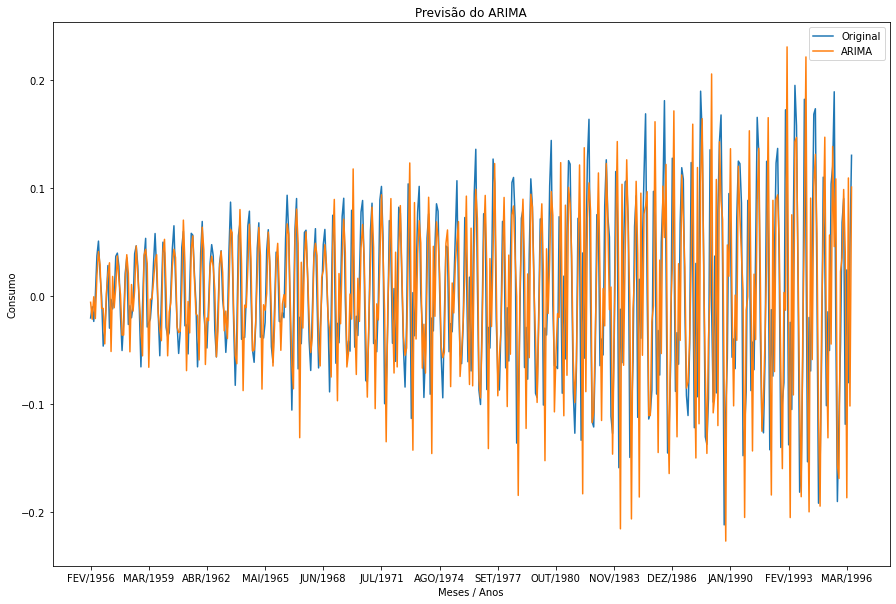

In [33]:
plotar_grafico({'Original': df_series, 'ARIMA': df_arima}, 
               {'titulo': 'Previsão do ARIMA', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'},
                 personalize=True)

# Resíduos da previsão do ARIMA (obtido através do RStudio)

A série residual será calculada a partir da diferença entre a série original e a predição do ARIMA. 
Os padrões não-lineares, que deixaram de ser modelados pelo ARIMA, serão modelados pelo SVR através do treino do modelo, com base na série residual. 
Ao realizar a predição do modelo do SVR, a predição dos resíduos será obtida.

In [34]:
# Importação
df_resid = pd.read_csv(f'{caminho_bdd}/residuals_ARIMA_eletric.csv', sep=',', header = 0, 
                       names = ['Resíduo_ARIMA'])
df_resid = mudar_index(df_resid[['Resíduo_ARIMA']], 'Resíduo_ARIMA')

arr_resid = np.array(df_resid['Resíduo_ARIMA'].copy())

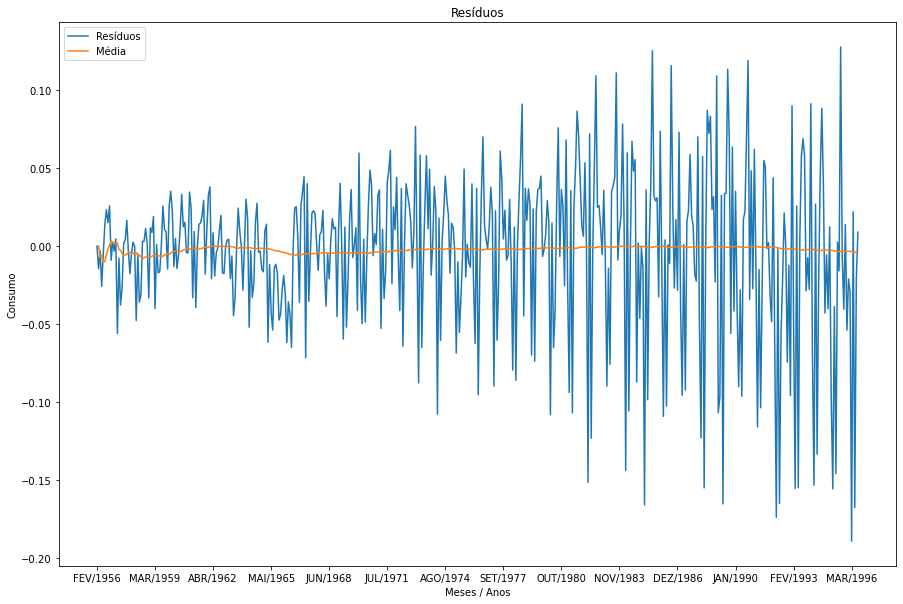

In [35]:
arr_resid_media = [np.mean(arr_resid[:x]) for x in range(len(arr_resid))]

plotar_grafico({'Resíduos': df_resid, 'Média': arr_resid_media}, 
               {'titulo': 'Resíduos', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

Assim como foi feito com a série original e a previsão do ARIMA, vamos verificar se a série de resíduos é estacionária ou não

No gráfico acima nota-se uma tendência constante (média constante). Sendo assim, conclui-se que esta é uma **série estacionária**.

Vamos verificar se a série residual é estacionária através dos testes de Dickey-Fuller e KPSS.

In [36]:
teste_dickey_fuller(arr_resid)

Teste Estatistico Dickey Fuller     -1.7267
Valor-P                              0.4174
Lags Usados                         12.0000
Número de observações usadas       473.0000
Valores Críticos 1%                 -3.4443
Valores Críticos 5%                 -2.8677
Valores Críticos 10%                -2.5700
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série **não é estacionária** (Valor P de 41% e o *valor crítico de 5%* é menor que o teste estatístico)

In [37]:
teste_kpss(arr_resid)

Teste Statistico KPSS     0.5849
Valor-P                   0.0240
Lags Usados              12.0000
Valores Críticos 10%      0.3470
Valores Críticos 5%       0.4630
Valores Críticos 2.5%     0.5740
Valores Críticos 1%       0.7390
dtype: float64

Confirmando o teste de Dickey Fuller, o teste KPSS também mostra que a série **não é estacionária**, pois o valor P está em 2,4% (<5%) e o teste estatístico está acima de qualquer valor crítico.

Como a série residual não é estacionária, vamos realizar a diferenciação para que ela se torne estacionária.

In [38]:
# Diferenciação 
if (diferenciado):
    arr_resid = np.diff(arr_resid)
    df_resid = mudar_index(df_resid, 'Resíduo_ARIMA')

Vamos verificar se a série residual se tornou estacionária após a diferenciação 

In [39]:
teste_dickey_fuller(arr_resid)

Teste Estatistico Dickey Fuller    -11.9697
Valor-P                              0.0000
Lags Usados                         12.0000
Número de observações usadas       472.0000
Valores Críticos 1%                 -3.4443
Valores Críticos 5%                 -2.8677
Valores Críticos 10%                -2.5700
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série **é estacionária** (Valor P de 0% e o *valor crítico de 5%* é maior que o teste estatístico)

In [40]:
teste_kpss(arr_resid)

Teste Statistico KPSS     0.0145
Valor-P                   0.1000
Lags Usados              12.0000
Valores Críticos 10%      0.3470
Valores Críticos 5%       0.4630
Valores Críticos 2.5%     0.5740
Valores Críticos 1%       0.7390
dtype: float64

Confirmando o teste de Dickey Fuller, o teste KPSS também mostra que a série **é estacionária**, pois o valor P está em 10% (>5%) e o teste estatístico está abaixo de qualquer valor crítico.

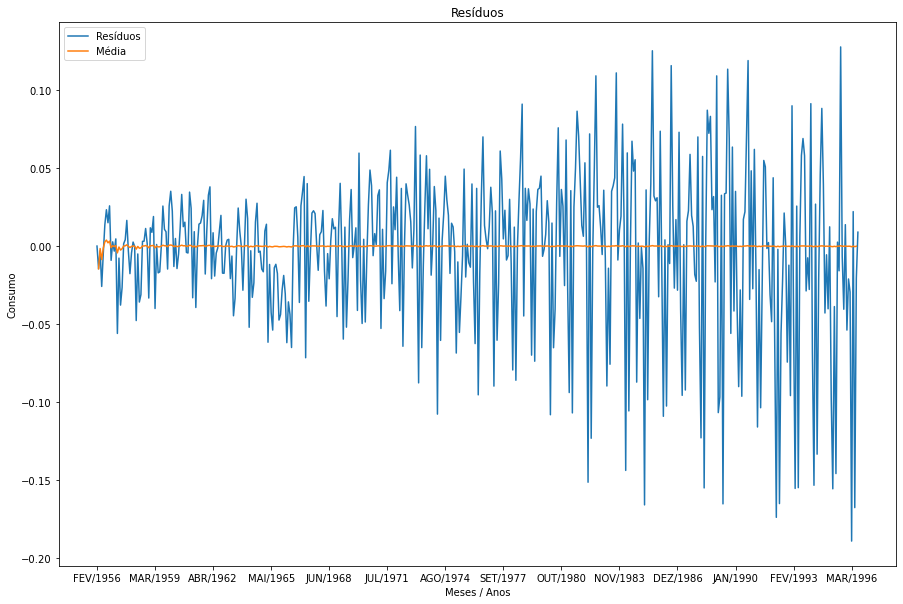

In [41]:
arr_resid_media = [np.mean(arr_resid[:x]) for x in range(len(arr_resid))]

plotar_grafico({'Resíduos': df_resid, 'Média': arr_resid_media}, 
               {'titulo': 'Resíduos', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

# SVR

Agora que temos todas as ferramentas que vamos utilizar, podemos preparar as séries para aplicar o SVR na série de resíduos do ARIMA, e somar o resultado (previsão do SVR) à série de resíduos do ARIMA. Com isso, buscamos aumentar a assertividade do modelo de previsão.

## Preparação e Divisão dos dados para treino do SVR

Além desta divisão, também é necessário separar a série original em valores de saída que são esperados para cada conjunto de valores de entrada.
* Ex: **[0, 1, 2, 3] para prever [4] *(lag = 4, nesse caso)***

 Para isso, é necessária uma função que recebe uma série e um lag como parâmetros e separa os dados de forma a estabelecer a saída esperada para cada conjunto de dados (*lag* dados) de entrada. O *lag* padrão será *lag = 12*.

### Função Útil
* Recebe uma série e um lag como parâmetros e separa os dados de forma a estabelecer a saída esperada para cada conjunto de dados (*lag* dados) de entrada. O *lag* padrão será *lag = 12*.

In [42]:
#  Função de preparação de dados
def preparar_dados(sequence, lag):
    x, y = list(), list()
 
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + lag
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    
    return np.array(x), np.array(y)

Também é necessária uma função para dividir as entradas e saídas de treino e de teste. Será usada em conjunto com a função *preparar_dados()*.

### Função Útil
* Função para dividir as entradas e saídas de treino e de teste. Será usada em conjunto com a função *preparar_dados()*.

In [43]:
# divisao = será equivalente a 70% do tamanho da lista de amostras (70% para treino)

def separar_treino_teste(arr_entrada, arr_saida, divisao = ''):
    divisao = divisao if divisao else round(len(arr_saida)*0.7)
    arr_e_treino = arr_entrada[:divisao]
    arr_s_treino = arr_saida[:divisao]
    
    arr_e_teste = arr_entrada[divisao:]
    arr_s_teste = arr_saida[divisao:]
    
    return arr_e_treino, arr_e_teste, arr_s_treino, arr_s_teste

In [44]:
# Preparação dos dados da série residual
arr_resid_in, arr_resid_out = preparar_dados(arr_resid, lag)

[arr_resid_in_train, arr_resid_in_test, 
 arr_resid_out_train, arr_resid_out_test] = separar_treino_teste(arr_resid_in, arr_resid_out)

print(arr_resid_in_train.shape)
print(arr_resid_out_train.shape)

print(arr_resid_in_test.shape)
print(arr_resid_out_test.shape)

(331, 12)
(331,)
(142, 12)
(142,)


### Definindo os melhores parâmetros para o SVR usando o GridSearchCV

In [45]:
regr = svm.SVR()

parameters = {'kernel':['rbf'], 
              'C':[1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'gamma':[1e-2, 1e-1, 1e-0, 1e1, 1e2],
              'epsilon':[1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}

clf = GridSearchCV(regr, parameters, scoring='neg_mean_squared_error')
clf.fit(arr_resid_in, arr_resid_out)

print(f'Melhores parâmetros: {clf.best_params_}')

Melhores parâmetros: {'C': 100.0, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}


### Aplicando o SVR com os parâmetros definidos

In [46]:
kernel = clf.best_params_['kernel']
C = clf.best_params_['C']
gamma = clf.best_params_['gamma']
epsilon = clf.best_params_['epsilon']

regr = svm.SVR(kernel = kernel, gamma = gamma, C = C, epsilon = epsilon)

# TREINAMENTO DO MODELO
regr.fit(arr_resid_in_train, arr_resid_out_train)

SVR(C=100.0, epsilon=0.01, gamma=0.1)

### Previsão do SVR dos resíduos 

In [47]:
# PREVISÃO
arr_prev_SVR = regr.predict(arr_resid_in_test)

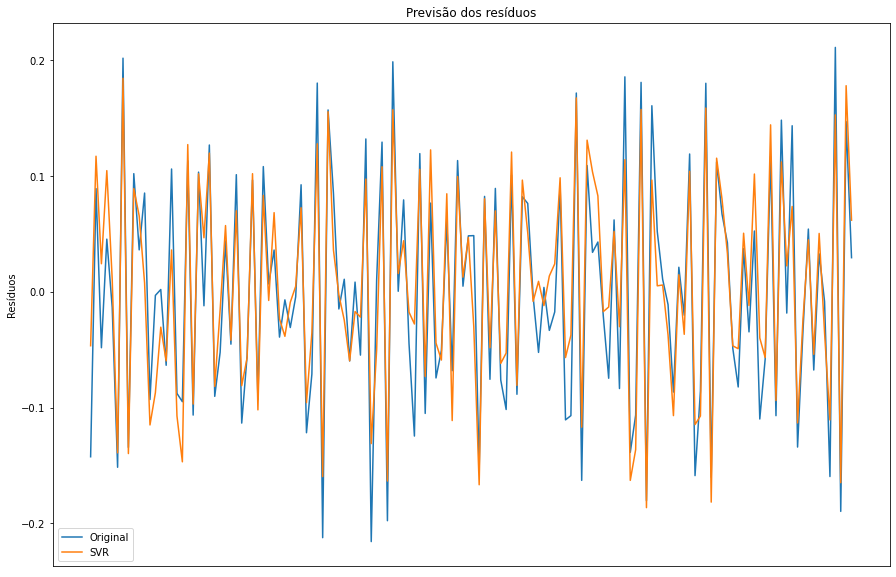

In [48]:
plotar_grafico({'Original': arr_resid_out_test, 'SVR': arr_prev_SVR}, 
               {'titulo': f'Previsão dos resíduos', 
                'x_label': '', 
                'y_label': 'Resíduos'})

### Preparando os dados da série original para comparar com as previsões 

In [49]:
# Preparação dos dados da série original. 
# arr_series_in = conjuntos de entrada, arr_series_out = valores de saída esperada para cada conjunto de entrada
# in = ENTRADA, out = SAÍDA ESPERADA

arr_series_in, arr_series_out = preparar_dados(arr_series, lag)

[arr_series_in_train, arr_series_in_test, 
 arr_series_out_train, arr_series_out_test] = separar_treino_teste(arr_series_in, arr_series_out)

### Preparando os dados da previsão do ARIMA para fazer a combinação linear com a previsão do SVR

In [50]:
# Preparação dos dados do ARIMA. 
# arr_arima_in = conjuntos de entrada, arr_arima_out = valores de saída esperada para cada conjunto de entrada
# in = ENTRADA, out = SAÍDA ESPERADA

arr_arima_in, arr_arima_out = preparar_dados(arr_arima, lag)

[arr_arima_in_train, arr_arima_in_test, 
 arr_arima_out_train, arr_arima_out_test] = separar_treino_teste(arr_arima_in, arr_arima_out)

arr_prev_arima = arr_arima_out_test

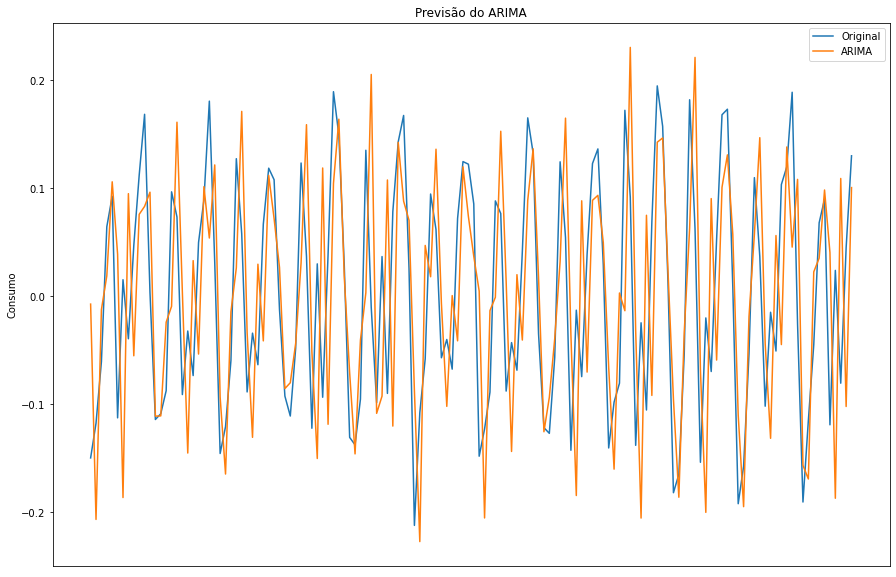

In [51]:
plotar_grafico({'Original': arr_series_out_test, 'ARIMA': arr_arima_out_test}, 
               {'titulo': f'Previsão do ARIMA', 
                'x_label': '', 
                'y_label': 'Consumo'})

### Previsão final = Previsão do ARIMA + Previsão dos resíduos (usando SVR)

In [52]:
arr_prev_final = arr_prev_arima + arr_prev_SVR

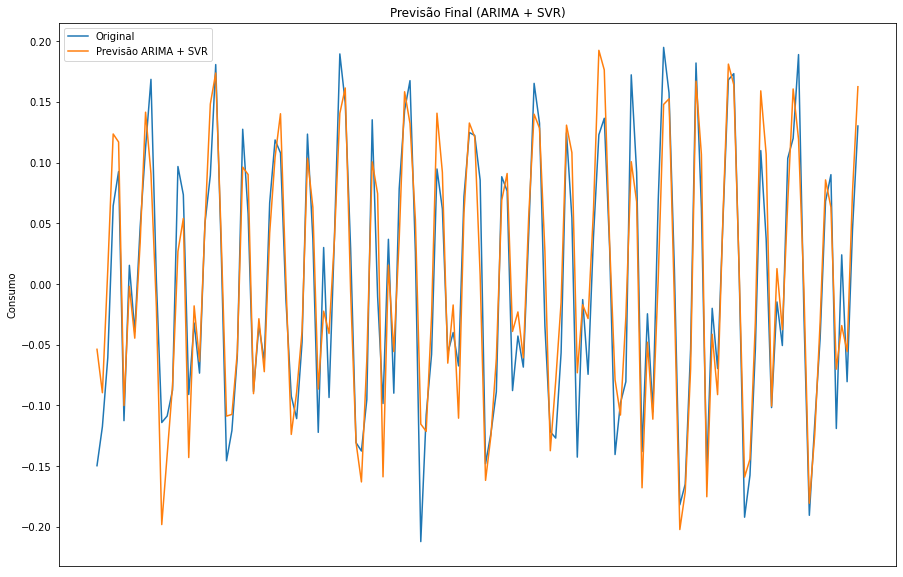

In [53]:
plotar_grafico({'Original': arr_series_out_test, 'Previsão ARIMA + SVR': arr_prev_final}, 
               {'titulo': f'Previsão Final (ARIMA + SVR)', 
                'x_label': '', 
                'y_label': 'Consumo'})

# Métricas para avaliar o modelo

Avalia-se o erro nos dados de treino para verificar se o modelo tem boa assertividade, e valida-se o modelo verificando o erro nos dados de teste (dados que não foram "vistos" pelo modelo).

Abaixo estão as principais métricas usadas para avaliar modelos de séries temporais.

### MAE - MEAN ABSOLUTE ERROR - (ERRO MÉDIO ABSOLUTO)

Essa métrica é muito semelhante ao erro médio da previsão mencionado acima, a única diferença é o erro com valor negativo, ou seja, a previsão com valor maior que o número real, é transformado em positivo e posteriormente a média é calculada.

Essa métrica é muito usada em séries temporais, pois há casos que o erro negativo pode zerar o positivo ou dar uma ideia que o modelo é preciso, no caso do MAE isso não acontece, pois essa métrica mostra o quanto a previsão está longe dos valores reais, independente se acima ou abaixo.

### MSE - MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO)

Essa métrica coloca mais peso nos erros maiores, pois cada valor individual do erro é elevado ao quadrado e posteriormente a média desses valores é calculada. Assim, essa métrica é muito sensível à outliers e coloca bastante peso nas previsões com erros mais significativos.

Diferente do MAE e MFE, os valores do MSE estão em unidades quadráticas e não na unidade do modelo.

### RMSE - ROOT MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO DA RAIZ)

Essa métrica é simplesmente a raiz quadrada do MSE, onde o erro volta a ter a unidade de medida do modelo, ela é muito usada em séries temporais porque é mais sensível à erros maiores devido ao processo de elevação ao quadrado que a originou.

**Vamos criar uma função para avaliar o erro dos dados com várias métricas de avaliação:**

In [54]:
def check_erro(orig, prev, nome_col='', nome_indice=''):
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    
    grupo_erro = [mse, rmse, mae]
    serie = pd.DataFrame(grupo_erro, index=['MSE','RMSE','MAE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

### Métricas para a previsão do ARIMA

In [55]:
erro_arima = check_erro(arr_series_out_test, 
                        arr_prev_arima, 
                        nome_col='Resultado (ARIMA)', 
                        nome_indice='Métricas')

erro_arima

,Resultado (ARIMA)
Métricas,
MSE,0.010234
RMSE,0.101161
MAE,0.085009


### Métricas para a previsão final (SVR + ARIMA)

In [56]:
erro_total = check_erro(arr_series_out_test, 
                        arr_prev_final, 
                        nome_col='Resultado (ARIMA+SVR)', 
                        nome_indice='Métricas')

erro_total

,Resultado (ARIMA+SVR)
Métricas,
MSE,0.001350
RMSE,0.036736
MAE,0.029268


### Diferença Percentual

Ao comparar os valores das métricas de erros entre a previsão do ARIMA e a previsão final (ARIMA + SVR), podemos avaliar quão maior são os resultados da previsão do ARIMA com relação a previsão final.

In [57]:
arr_erro_arima = [i.tolist()[0] for i in list(np.array(erro_arima))]
arr_erro_total = [i.tolist()[0] for i in list(np.array(erro_total))]
sinal = []

for i in range(3):
    a  = '-' if arr_erro_arima[i] < arr_erro_total[i] else '+'
    sinal.append(a)
arr_diferenca = [f'{sinal[i]}{((arr_erro_arima[i]/arr_erro_total[i])*100):.2f}%' for i in range(3)]
df_diferenca = pd.DataFrame({'DIferença': arr_diferenca}, index=['MSE','RMSE','MAE'])
df_diferenca

,DIferença
MSE,+758.30%
RMSE,+275.37%
MAE,+290.45%


Com isso, conclui-se que o resultado da previsão ARIMA + SVR é mais assertiva do que apenas a previsão ARIMA.

### Adicionando as datas ao Index das previsões

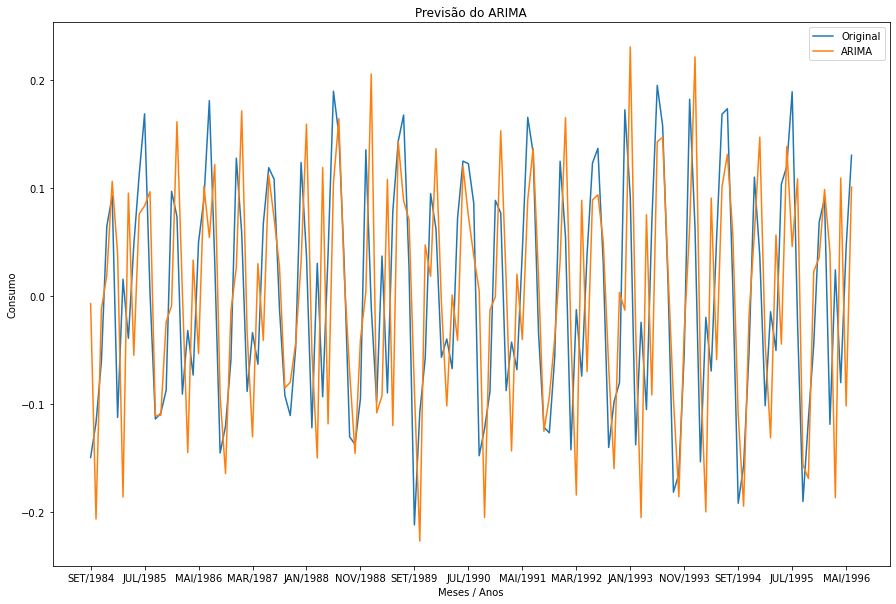

In [58]:
arr_prev_arima_total = np.append(arr_series[:-len(arr_prev_final)], arr_prev_arima)
df_prev_arima_total = mudar_index(arr_prev_arima_total)

plotar_grafico({'Original': df_series.iloc[-(len(arr_prev_final)):, 0],
                'ARIMA': df_prev_arima_total.iloc[-(len(arr_prev_final)):, 0]}, 
               {'titulo': f'Previsão do ARIMA', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

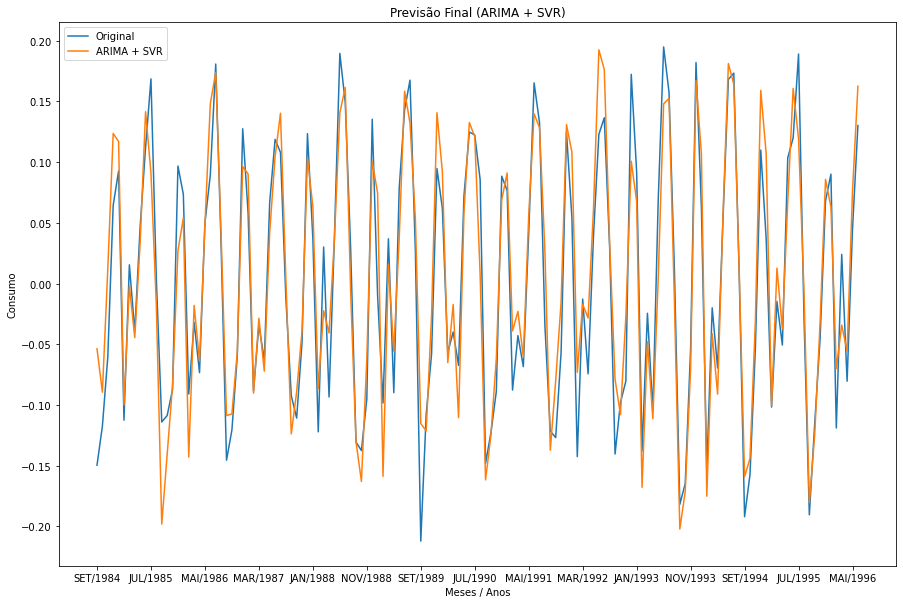

In [59]:
arr_prev_final_total = np.append(arr_series[:-len(arr_prev_final)], arr_prev_final)
df_prev_final_total = mudar_index(arr_prev_final_total)

plotar_grafico({'Original': df_series.iloc[-(len(arr_prev_final)):, 0], 
                'ARIMA + SVR': df_prev_final_total.iloc[-(len(arr_prev_final)):, 0]}, 
               {'titulo': f'Previsão Final (ARIMA + SVR)', 
                'x_label': 'Meses / Anos', 
                'y_label': 'Consumo'})

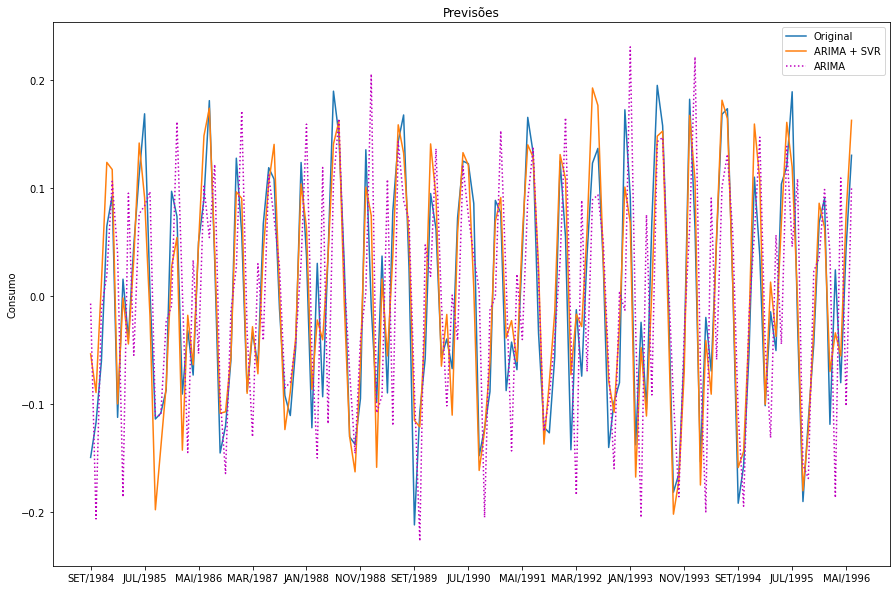

In [60]:
plotar_grafico({'Original': df_series.iloc[-(len(arr_prev_final)):, 0], 
                'ARIMA + SVR': df_prev_final_total.iloc[-(len(arr_prev_final)):, 0],
                'ARIMA': df_prev_arima_total.iloc[-(len(arr_prev_final)):, 0]},
               {'titulo': f'Previsões', 
                'x_label': '', 
                'y_label': 'Consumo'},
                personalize=True)